In [65]:
import os
import re
from pathlib import Path

import anndata
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from umap import UMAP
from sklearn.preprocessing import StandardScaler

In [66]:
from violet.utils.dataloaders import listfiles

In [67]:
img_dir = '/data/violet/sandbox/tcia_pda_run1/st/normalized/'
train_dir = '/data/violet/sandbox/tcia_pda_run1/st/train_v2/images'
val_dir = '/data/violet/sandbox/tcia_pda_run1/st/val_v2/images'

Path(train_dir).mkdir(parents=True, exist_ok=True)
Path(val_dir).mkdir(parents=True, exist_ok=True)

In [68]:
adata_map = {}
fmap = pd.read_csv('/home/estorrs/spatial-analysis/data/sample_map.txt', sep='\t', index_col=0)
for s, fp, d, t in zip(fmap.index, fmap['spaceranger_output'], fmap['disease'], fmap['tissue_type']):
    if 'pdac' == d and t == 'ffpe':
        adata_map[s] = sc.read_visium(fp)
        adata_map[s].var_names_make_unique()
        sc.pp.normalize_total(adata_map[s], inplace=True)
        sc.pp.log1p(adata_map[s])
adata_map

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


{'HT264P1_S1H2Fs1_U1': AnnData object with n_obs × n_vars = 3234 × 17943
     obs: 'in_tissue', 'array_row', 'array_col'
     var: 'gene_ids', 'feature_types', 'genome'
     uns: 'spatial', 'log1p'
     obsm: 'spatial',
 'HT270P1_S1H1Fs5U1': AnnData object with n_obs × n_vars = 3940 × 17943
     obs: 'in_tissue', 'array_row', 'array_col'
     var: 'gene_ids', 'feature_types', 'genome'
     uns: 'spatial', 'log1p'
     obsm: 'spatial'}

In [69]:
a = adata_map['HT270P1_S1H1Fs5U1']
a

AnnData object with n_obs × n_vars = 3940 × 17943
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'

In [70]:
markers = {
    't cell': ['PTPRC', 'CD3G', 'CD4', 'CD8A', 'FOXP3', 'GZMB', 'NKG7', 'IL7R'],
    'macrophage/monocyte': ['CD14', 'FCGR3A', 'CD68'],
    'dc': ['ITGAX'],
    'b': ['MS4A1'],
    'endothelial': ['PECAM1'],
    'tumor/epithelial': ['CDH1', 'EPCAM', 'KRT18'],
    'acinar': ['PRSS1'],
    'islet': ['SYP'],
    'fibroblast': ['BGN', 'ACTA2']
}
genes = []
for vs in markers.values(): genes += vs


... storing 'feature_types' as categorical
... storing 'genome' as categorical


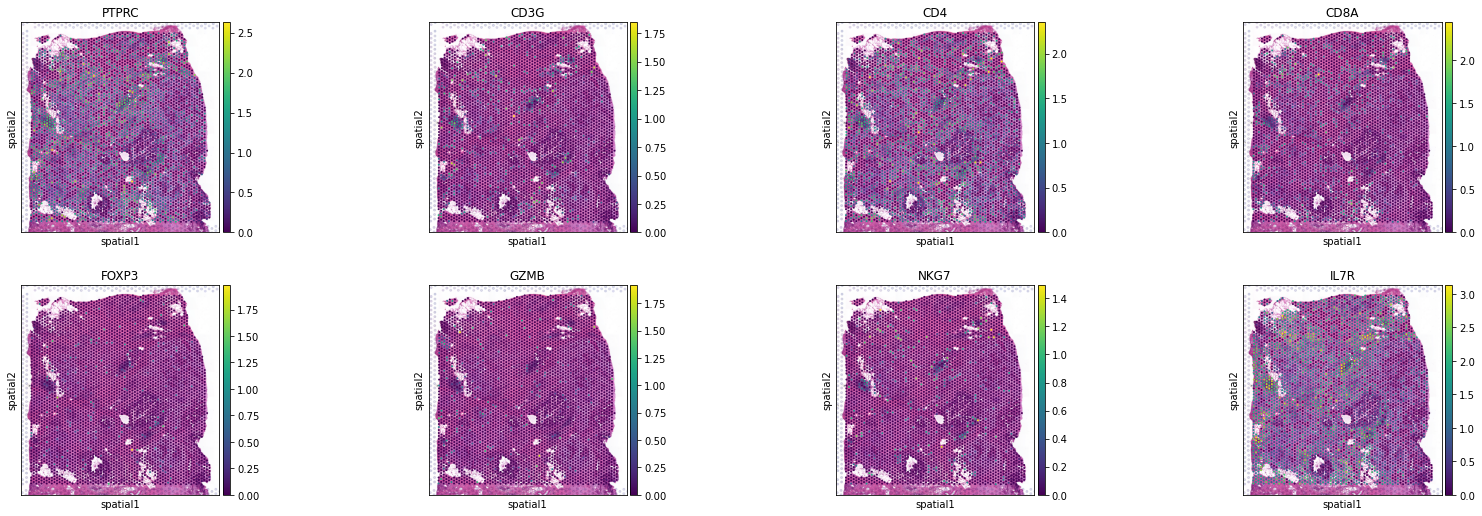

In [71]:
sc.pl.spatial(a, color=markers['t cell'])

In [72]:
def create_target_data(sample, adata):
    adata = adata[:, genes]
    df = pd.DataFrame(data=adata.X.toarray(), columns=genes,
                     index=[f'{sample}_{x}' for x in adata.obs.index])
    return df

In [73]:
create_target_data('HT270P1_S1H1Fs5U1', a)

,PTPRC,CD3G,CD4,CD8A,FOXP3,GZMB,NKG7,IL7R,CD14,FCGR3A,...,ITGAX,MS4A1,PECAM1,CDH1,EPCAM,KRT18,PRSS1,SYP,BGN,ACTA2
HT270P1_S1H1Fs5U1_AAACAACGAATAGTTC-1,1.157185,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.737395,0.000000,0.000000,...,0.000000,0.000000,0.737395,1.157185,1.157185,0.000000,2.274583,0.0,2.020607,1.679324
HT270P1_S1H1Fs5U1_AAACAAGTATCTCCCA-1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.811176,1.484273,0.000000,...,0.000000,1.811176,0.995427,0.000000,0.000000,0.995427,2.254381,0.0,2.560412,2.684237
HT270P1_S1H1Fs5U1_AAACAATCTACTAGCA-1,0.933786,0.000000,0.933786,0.000000,0.0,0.0,0.0,1.408116,0.933786,0.933786,...,0.933786,0.000000,0.933786,1.408116,0.933786,1.408116,2.328714,0.0,2.799792,2.591740
HT270P1_S1H1Fs5U1_AAACACCAATAACTGC-1,0.000000,0.000000,0.909446,0.000000,0.0,0.0,0.0,0.554731,0.909446,0.000000,...,0.554731,0.000000,0.554731,1.549129,1.549129,2.364541,1.377731,0.0,3.492967,2.761873
HT270P1_S1H1Fs5U1_AAACAGAGCGACTCCT-1,1.548496,0.000000,0.000000,1.048089,0.0,0.0,0.0,2.129276,0.000000,1.048089,...,1.048089,0.000000,1.548496,0.000000,1.548496,0.000000,2.494293,0.0,3.480850,2.328348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HT270P1_S1H1Fs5U1_TTGTTGTGTGTCAAGA-1,0.000000,0.878957,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.878957,...,0.000000,0.878957,1.339406,0.000000,0.000000,0.000000,1.892140,0.0,3.216576,3.767035
HT270P1_S1H1Fs5U1_TTGTTTCACATCCAGG-1,0.622204,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.622204,1.821023,1.821023,2.429777,1.493379,0.0,3.259166,2.695199
HT270P1_S1H1Fs5U1_TTGTTTCATTAGTCTA-1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.963197,0.593343,1.619418,2.692633,0.963197,0.0,3.322551,2.512880
HT270P1_S1H1Fs5U1_TTGTTTCCATACAACT-1,1.211790,0.000000,1.211790,0.000000,0.0,0.0,0.0,1.743791,0.000000,0.000000,...,0.000000,0.000000,1.211790,1.211790,0.000000,1.211790,1.743791,0.0,3.527328,3.202540


In [74]:
sample_to_target_df = {s:create_target_data(s, a) for s, a in adata_map.items()}

In [75]:
sample_to_target_df.keys()

dict_keys(['HT264P1_S1H2Fs1_U1', 'HT270P1_S1H1Fs5U1'])

In [76]:
val_samples = ['HT264P1_S1H2Fs1_U1']
train_df, val_df = None, None
for s, df in sample_to_target_df.items():
    if s not in val_samples:
        if train_df is None:
            train_df = df
        else:
            train_df = pd.concat((train_df, df))
    else:
        if val_df is None:
            val_df = df
        else:
            val_df = pd.concat((val_df, df))
train_df.shape, val_df.shape            

((3940, 21), (3234, 21))

In [77]:
train_df.index.name, val_df.index.name = 'spot_id', 'spot_id'
train_df.to_csv(os.path.join(train_dir, '..', 'targets.txt'), sep='\t')
val_df.to_csv(os.path.join(val_dir, '..', 'targets.txt'), sep='\t')

In [78]:
import shutil

In [79]:
fps = sorted(listfiles(img_dir))
len(fps), fps[:6]

(21520,
 ['/data/violet/sandbox/tcia_pda_run1/st/normalized/HT264P1_S1H2Fs1_U1_AAACAAGTATCTCCCA-1_1.jpeg',
  '/data/violet/sandbox/tcia_pda_run1/st/normalized/HT264P1_S1H2Fs1_U1_AAACAAGTATCTCCCA-1_4.jpeg',
  '/data/violet/sandbox/tcia_pda_run1/st/normalized/HT264P1_S1H2Fs1_U1_AAACAAGTATCTCCCA-1_8.jpeg',
  '/data/violet/sandbox/tcia_pda_run1/st/normalized/HT264P1_S1H2Fs1_U1_AAACAGAGCGACTCCT-1_1.jpeg',
  '/data/violet/sandbox/tcia_pda_run1/st/normalized/HT264P1_S1H2Fs1_U1_AAACAGAGCGACTCCT-1_4.jpeg',
  '/data/violet/sandbox/tcia_pda_run1/st/normalized/HT264P1_S1H2Fs1_U1_AAACAGAGCGACTCCT-1_8.jpeg'])

In [80]:
# only 4x
fps = [fp for fp in fps if '_4.jpeg' in fp]
len(fps)

7173

In [81]:
def extract_tile(fp, scale=.25):
    img = np.asarray(Image.open(fp))
    r = int((img.shape[0] * scale) // 2)
    c = int(img.shape[0] // 2)
    return img[c-r:c+r, c-r:c+r]

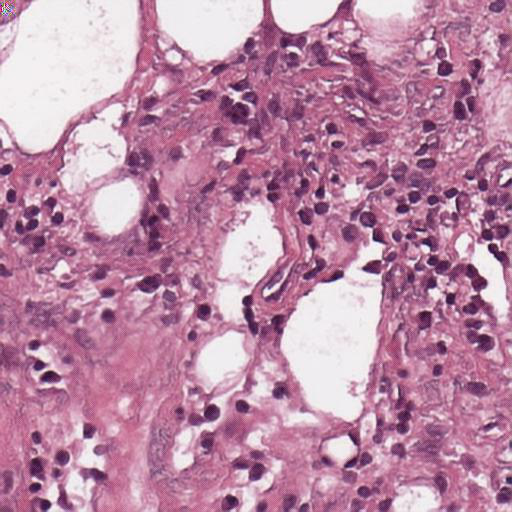

In [82]:
from PIL import Image
im = Image.open('/data/violet/sandbox/tcia_pda_run1/st/normalized/HT264P1_S1H2Fs1_U1_AAACAGAGCGACTCCT-1_4.jpeg')
im

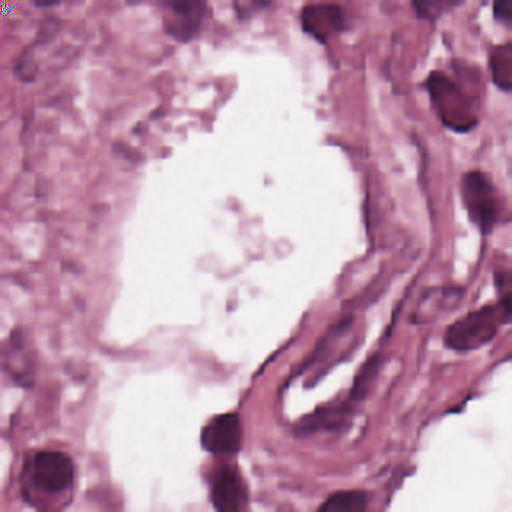

In [83]:
from PIL import Image
im = Image.open('/data/violet/sandbox/tcia_pda_run1/st/normalized/HT264P1_S1H2Fs1_U1_AAACAGAGCGACTCCT-1_1.jpeg')
im

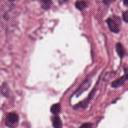

In [84]:
im = Image.fromarray(extract_tile(
    '/data/violet/sandbox/tcia_pda_run1/st/normalized/HT264P1_S1H2Fs1_U1_AAACAGAGCGACTCCT-1_4.jpeg'))
im

In [85]:
resize = (288, 288)
for fp in fps:
    fname = fp.split('/')[-1]
    s = re.sub(r'^(.*)_[ACTG]+-1_[0-9]+.jpeg$', r'\1', fname)
    im = Image.fromarray(extract_tile(fp, scale=.25))
    if s not in val_samples:
        Image.open(fp).resize(resize).save(os.path.join(train_dir, fname))
        im.resize(resize).save(os.path.join(train_dir, fname.replace('_4.jpeg', '_1.jpeg')))
    else:
        Image.open(fp).resize(resize).save(os.path.join(val_dir, fname))
        im.resize(resize).save(os.path.join(val_dir, fname.replace('_4.jpeg', '_1.jpeg')))

In [107]:
fps = list(listfiles('/data/violet/sandbox/tcia_pda_run1/tcia/raw/test_A/'))
len(fps), fps[:6]

(4018961,
 ['/data/violet/sandbox/tcia_pda_run1/tcia/raw/test_A/C3L-01160-25_134_271_4.jpeg',
  '/data/violet/sandbox/tcia_pda_run1/tcia/raw/test_A/C3L-01637-21_61_75_4.jpeg',
  '/data/violet/sandbox/tcia_pda_run1/tcia/raw/test_A/C3L-00589-22_83_89_4.jpeg',
  '/data/violet/sandbox/tcia_pda_run1/tcia/raw/test_A/C3L-01160-24_123_154_4.jpeg',
  '/data/violet/sandbox/tcia_pda_run1/tcia/raw/test_A/C3L-03129-23_132_444_4.jpeg',
  '/data/violet/sandbox/tcia_pda_run1/tcia/raw/test_A/C3L-00622-22_89_490_4.jpeg'])

In [110]:
small = [fp for fp in fps if 'C3L-00401-22' in fp]
len(small), small[:2]

(20200,
 ['/data/violet/sandbox/tcia_pda_run1/tcia/raw/test_A/C3L-00401-22_135_125_4.jpeg',
  '/data/violet/sandbox/tcia_pda_run1/tcia/raw/test_A/C3L-00401-22_195_90_4.jpeg'])

In [111]:
resize = (288, 288)
out = '/data/violet/sandbox/tcia_pda_run1/tcia/raw/C3L-00401-22/'
Path(out).mkdir(parents=True, exist_ok=True)
for fp in small:
    fname = fp.split('/')[-1]
    s = re.sub(r'^(.*)_[0-9]+_[0-9]+_[0-9]+.jpeg$', r'\1', fname)
    im = Image.fromarray(extract_tile(fp, scale=.25))
    Image.open(fp).resize(resize).save(os.path.join(out, fname))
    im.resize(resize).save(os.path.join(out, fname.replace('_4.jpeg', '_1.jpeg')))